In [36]:
import pandas as pd
import numpy as np
from data_prepare import zero_to_mean, zero_to_nan

df = pd.read_csv("./data/diabetes.csv")

target = "Outcome"
labels = df[target]
df = df.drop(columns=[target, "Pregnancies"])
# df = df.drop(columns=[target])
num_cols = df.columns # "X"

non_zero_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Pipeline

In [37]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# zero_to_mean(df)
non_zero_pipeline = Pipeline([
    ('impute_zero_to_nan', FunctionTransformer(zero_to_nan)),
    ('imputer', SimpleImputer(strategy='mean')),
])

pre_imputation = ColumnTransformer(
    transformers=[
        ('non_zero_clean', non_zero_pipeline, non_zero_cols),
    ],
    remainder='passthrough' # tudo que não for non_zero_cols passa sem mexer
)

preprocessor = Pipeline([
    # ('scaler', StandardScaler())
    ('pre_clean', pre_imputation),
    ('powerTransformer', PowerTransformer()),
    # ('minMax', MinMaxScaler()),
    # ('robust', RobustScaler()),
])

# Methods - Prepare

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

def stratify(df: pd.DataFrame, labels: pd.DataFrame):
    train_set, test_set, train_labels, test_labels = train_test_split(
        df,
        labels,
        test_size = 0.20,
        random_state = 32,
        stratify=labels,
    )

    return train_set, train_labels, test_set, test_labels

def prepare_train(df: pd.DataFrame):
    prepared_data = preprocessor.fit_transform(df)

    df_transformed = pd.DataFrame(
        prepared_data,
        columns=num_cols
    )

    return df_transformed

def prepare_predict(df: pd.DataFrame, all_feature_names: list):
    prepared_data = preprocessor.transform(df)
    df_transformed = pd.DataFrame(prepared_data, columns=all_feature_names, index=df.index)

    return df_transformed

# Methods - Evaluation (R2, MAE, MSE...)

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate(y_true, y_pred):
    print("Avaliação do Modelo:")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    print("\nMatriz de Confusão:\n", confusion_matrix(y_true, y_pred))

In [38]:
# imputed = pre_imputation.fit_transform(df)
# imputed = pd.DataFrame(imputed, columns=num_cols)
# imputed["Glucose"].describe()
train_set, train_labels, test_set, test_labels = stratify(df, labels)

# Ver o step de conversão de ZEROS para médias
 apenas para garantir que está funcionando

In [27]:
# Ver o step intermediário para garantir que os valores ZERO foram convertidos para média
intermediate = preprocessor.named_steps['pre_clean'].transform(df)
intermediate_df = pd.DataFrame(
    intermediate,
    columns=num_cols
)
intermediate_df["Glucose"].describe()

count    768.000000
mean     121.686860
std       30.435949
min       44.000000
25%       99.750000
50%      117.000000
75%      140.250000
max      199.000000
Name: Glucose, dtype: float64

In [39]:
train_prepared = prepare_train(train_set)

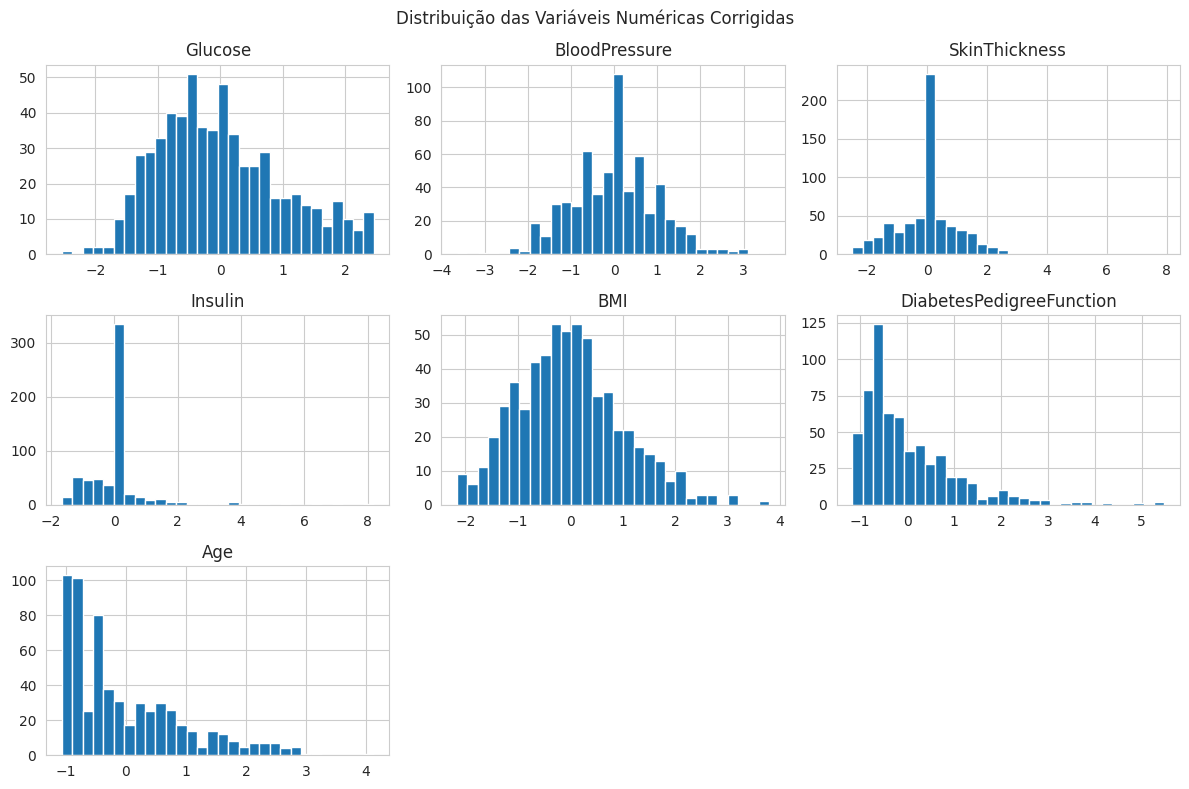

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
train_prepared.hist(bins=30, figsize=(12, 8))
plt.suptitle("Distribuição das Variáveis Numéricas Corrigidas")
plt.tight_layout()

# Models

In [40]:
from sklearn.linear_model import LogisticRegression
def logisticRegressionModel(
        train_prepared: pd.DataFrame,
        train_labels: pd.DataFrame,
        test_set: pd.DataFrame,
        test_labels: pd.DataFrame,
        cols: list,
):
    model = LogisticRegression()
    model.fit(train_prepared, train_labels)

    # df_test_imputed = pre_imputation.transform(test_set)
    # df_test_imputed = pd.DataFrame(df_test_imputed, columns=num_cols)
    # test_prepared = prepare_predict(df_test_imputed, cols)

    # zero_to_mean(test_set)
    test_prepared = prepare_predict(test_set, cols)

    predictions = model.predict(test_prepared)
    evaluate(test_labels, predictions)

#Avaliação do Modelo - no pregnancy, with non zero
# Acurácia: 0.7208
# Precisão: 0.6222
# Recall: 0.5185
# F1-Score: 0.5657

#Avaliação do Modelo - no pregnancy, withOUT non zero
#Acurácia: 0.7338
#Precisão: 0.6512
#Recall: 0.5185
#F1-Score: 0.5773

# Avaliação do Modelo - with pregnancy - with non zero
# Acurácia: 0.6948
# Precisão: 0.5778
# Recall: 0.4815
# F1-Score: 0.5253

# Avaliação do Modelo - Sem pipe de NON ZEROS
# Acurácia: 0.7727
# Precisão: 0.7714
# Recall: 0.5000
# F1-Score: 0.6067

# Avaliação do Modelo - Com zero_to_mean antes da pipe
# Acurácia: 0.7857
# Precisão: 0.8182
# Recall: 0.5000
# F1-Score: 0.6207

# Avaliação do Modelo - Com Pipe nonZero e PowerTransformer
# Acurácia: 0.7987
# Precisão: 0.8485
# Recall: 0.5185
# F1-Score: 0.6437

Avaliação do Modelo:
Acurácia: 0.7987
Precisão: 0.8485
Recall: 0.5185
F1-Score: 0.6437

Matriz de Confusão:
 [[95  5]
 [26 28]]


In [ ]:
logisticRegressionModel(
    train_prepared,
    train_labels,
    test_set,
    test_labels,
    num_cols,
)